In [65]:
#Imports and Settings
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from operator import mul
import seaborn as sn
import random

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Helper Functions
from helper import predict, confusion_matrix1, calculate_threshold_values, plot_roc
#Pandas Settings to Display Rows and Cols
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

#Matplotlib Style Settings
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

#Pandas Standaridzer for Float Formatting
#pd.options.display.float_format = '{:,.2f}'.format
#pd.reset_option('display.float_format')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

In [66]:
# Looping through data folder to concat CSV's into one big dataframe
# 1002400 rows in dataset
# 63 columns
# Reinitialize HERE

for i,name in tqdm(enumerate(glob.glob('data/CSV/*'))):
    if i == 0:
        df = pd.read_csv(name)
    df2 = pd.read_csv(name)
    concat = pd.concat([df,df2],ignore_index=True)
    df = concat

In [67]:
#Back Up Reinitilization 
data = df.copy()

In [68]:
# Reinitilize DF
%time df = data.copy()

CPU times: user 310 ms, sys: 178 ms, total: 488 ms
Wall time: 514 ms


In [69]:
#Trimming off extraneous columns
df = df.iloc[:,1:57]
df = df.drop(['Classics_Request_ID','End_Of_Run','Play_Dates','Start_Date','Local','Rental_Measure','Boxoffice_Net',
              'Film_Rental','To_Receive','FRM_Perc','Min_Max','MG_FF','Price','Customer_Reference','Office',
             'Remark','Payer_Remark','DType','Aspect_Ratio','Sound_System','Seat_Type','Amenity','Frame_Rate',
             'Resolution','Projection_Type','Licensor','L','Hire','Rem_','Rem_Date','Media_Type','Dim_','LV','Circuit'],axis=1)
#Data Leakage
#df = df.drop('Admissions',axis=1)
#df.head(2)

In [70]:
#Drop any duplicate ID's
df.drop_duplicates('LA_No',inplace=True)

#Dropping any non SP payments
df = df[df['FRM']=='sp'] 

# Only looking at records with grosses returned
df = df[df['Status']=='Returns In']

df = df[df.Division != 'CLASSICS']

#Dropping 500 NAN media formats
df = df.dropna(axis=0)

#Not in YT Data
df = df[df.Release !='THEY SHALL NOT GROW OLD']
df = df[df.Release !='FANTASTIC BEASTS AND WHERE TO FIND THEM']

In [71]:
df['First_Date'] = pd.to_datetime(df['First_Date'])
df['Last_Date'] = pd.to_datetime(df['Last_Date'])

df['Boxoffice'] = df['Boxoffice'].astype(str)
df['Boxoffice'] = df['Boxoffice'].apply(lambda x: x.replace(',', ''))
df['Boxoffice'] = df['Boxoffice'].astype(float)
df['T_No'] = df['T_No'].astype(float)

# Removed Admissions because of data leakage
df['Admissions'] = df['Admissions'].astype(str)
df['Admissions'] = df['Admissions'].apply(lambda x: x.replace(',', ''))
df['Admissions'] = df['Admissions'].astype(float)


In [72]:
def format_assign(x):
    if 'IMAX' in x or 'IXD'in x or 'DIMX' in x:     
        return 'IMAX'
    if 'PLF' in x or 'PLD' in x:
        return 'PLF'
    elif '3D' in x:
        return '3D'
    else:
        return '2D'

def seeks_run(x):
    if 'FIRST' in x:
        return 'FIRST RUN'
    elif 'LATE' in x:
        return 'LATE RUN'
    elif 'SUB' in x:
        return 'SUB RUN'
    else:
        return 'OTHER'
    # Intermediate Run, Other-Temp Close, IMAX, Art House, Calendar, Classics

df['Media_Formats'] = df['Media_Formats'].astype(str)
df['Media_Formats'] = df['Media_Formats'].swifter.apply(format_assign)
df['Seeks_Run'] = df['Seeks_Run'].swifter.apply(seeks_run)

# Opening Weekend DF

In [73]:
#Only opening week
ow_df = df[df['Seeks_Run']=='FIRST RUN'].sort_values(['Theatre','Release','T_No'])
ow_df = ow_df[ow_df['T_No']==1]
ow_df.reset_index(inplace=True)
ow_df.drop(['index','FRM','LA_No','Status','Last_Date','Terms_Perc','Branch','Area'],axis=1,inplace=True)


In [74]:
ow_df['id'] = ow_df['Theatre']+ow_df['City']+ow_df['Payer']

# Anonymizing Data

In [75]:
from faker import Faker

In [76]:
# Number of values to annoymize
# 6022 Theatres
# 4661 Film Buyer/Buying Circuit/Payer
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['Theatre','Film_Buyer','Buying_Circuit','Payer']].nunique())

Theatre           6001
Film_Buyer        1044
Buying_Circuit     795
Payer             2789
dtype: int64


In [77]:
confid_users = list(df.Payer.unique())
confid_users.extend(list(df.Buying_Circuit.unique()))
confid_users.extend(list(df.Film_Buyer.unique()))

In [78]:
distinct_confid = set(confid_users)

In [79]:
Faker.seed(2)
fake = Faker()
fake_names = []
for _ in tqdm(range(5300)):
    fake_names.append(fake.company())
fake_names = set(fake_names)
fake_names = list(fake_names)

In [80]:
confid_dict = dict.fromkeys(distinct_confid)
for key,value in tqdm(confid_dict.items()):
    confid_dict[key] = random.sample(fake_names,1)[0]

In [81]:
cinema_names = pd.read_csv('data/extra_data/Cinema_names.csv',header=None)

In [82]:
cinema_names;

In [83]:
cinema_list = []
for n in tqdm(range(0,674)):
    if len(cinema_names[0].apply(lambda x: x.split(' '))[n])>1:
        cinema_list.append(cinema_names[0].apply(lambda x: x.split(' '))[n][1])
    else:
        continue

In [84]:
#Using Unique DF ID isntead of just theatre
suffixes = ['Theaters','Cinemas','Movies','Flicks','Screens','Forum','Marquee']
maccs_theatres = ow_df['id'].unique().tolist()
maccs_theatres_dict = dict.fromkeys(maccs_theatres)

In [85]:
for key,value in maccs_theatres_dict.items():
    maccs_theatres_dict[key] = random.choice(cinema_list) +' '+ random.choice(cinema_list) + ' '+ random.choice(suffixes) 

In [86]:
%time ow_df['id'].replace(maccs_theatres_dict,inplace=True)
%time ow_df['Buying_Circuit'].replace(confid_dict,inplace=True)
%time ow_df['Film_Buyer'].replace(confid_dict,inplace=True)
%time ow_df['Payer'].replace(confid_dict,inplace=True)

CPU times: user 54.7 s, sys: 2.16 s, total: 56.9 s
Wall time: 1min 9s
CPU times: user 32 s, sys: 1.35 s, total: 33.3 s
Wall time: 40 s
CPU times: user 37.4 s, sys: 1.48 s, total: 38.9 s
Wall time: 45.9 s
CPU times: user 46.2 s, sys: 1.54 s, total: 47.8 s
Wall time: 53 s


In [143]:
ow_df['Theatre'] = ow_df['id']
ow_df.drop('id',axis=1,inplace=True)

In [250]:
#Total Opening Week Numbers
#with pd.option_context('display.float_format','{:,.2f}'):
ow_bo = ow_df.groupby('Release').sum()['Boxoffice']
ow_bo = ow_bo.astype(int)
ow_bo = ow_bo.reset_index()
ow_bo.drop('Boxoffice',axis=1,inplace=True);

# Opening Weekend DataFrame

In [251]:
ow_data = ow_df.merge(ow_bo,how='left',left_on='Release',right_on='Release')

In [252]:
labels_3=['Low','Mid','High']
fb_rank = dict(pd.qcut(ow_data.groupby('Film_Buyer')['Boxoffice'].sum(),q=3,labels=labels_3))
bc_rank = dict(pd.qcut(ow_data.groupby('Buying_Circuit')['Boxoffice'].sum(),q=3,labels=labels_3))
payer_rank = dict(pd.qcut(ow_data.groupby('Payer')['Boxoffice'].sum(),q=3,labels=labels_3))
tvm_rank = dict(pd.qcut(ow_data.groupby('TV_Market')['Boxoffice'].sum(),q=3,labels=labels_3))
city_rank = dict(pd.qcut(ow_data.groupby('City')['Boxoffice'].sum(),q=3,labels=labels_3))

In [253]:
ow_data['Film_Buyer'] = ow_data['Film_Buyer'].map(fb_rank)
ow_data['Buying_Circuit'] = ow_data['Buying_Circuit'].map(bc_rank)
ow_data['Payer'] = ow_data['Payer'].map(payer_rank)
ow_data['TV_Market'] = ow_data['TV_Market'].map(tvm_rank)
ow_data['City'] = ow_data['City'].map(city_rank)


# TMDb Movie Data

In [90]:
wb_list = df['Release'].unique().tolist()

In [91]:
clean = []
for title in wb_list:
    save = title.split("(")
    clean.append(save[0])

In [92]:
clean;

In [93]:
import difflib
import itertools
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [94]:
genre_df = pd.read_csv('data/extra_data/wb_df.csv')
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))

#Matching between TMDb and WB
genre_df.at[9,'title'] = "HOUSE, THE"
genre_df.at[29,'title'] = "MEG, THE"
genre_df.at[31,'title'] = "NUN, THE"
genre_df.at[35,'title'] = "MULE, THE"
genre_df.at[44,'title'] = "SHAFT (2074539)"
genre_df = genre_df[genre_df.title !='They Shall Not Grow Old']
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))
genre_df.at[12,'title'] = "IT (2017)"
genre_df.at[38,'title'] = "ISN'T IT ROMANTIC"
genre_df.at[27,'title'] = "OCEAN'S 8"

genre_df = genre_df.drop(['genre_ids','Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
# Adding OW field
genre_df = genre_df.merge(ow_bo,how='left',left_on='title',right_on='Release')

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [95]:

# Adding Comp Library Fields
comp_library = pd.read_csv('data/extra_data/Comparison Library - Test.xlsx - Database.csv')
comp_library = comp_library[['TITLE','Dist','# of Runs','Genre','Rating','Season','WIDE                --------              Open Date']]
comp_library = comp_library[comp_library['Dist']=='WB']

comp_library['release_date'] = pd.to_datetime(comp_library['WIDE                --------              Open Date'])
comp_library.drop('WIDE                --------              Open Date',axis=1,inplace=True)
comp_library['year'] = comp_library['release_date'].dt.year
comp_library = comp_library[comp_library['year']>=2017]
comp_library = comp_library[comp_library['year']<2020]

comp_library['title'] = comp_library['TITLE'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.3)))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("{'",''))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("'}",''))


comp_library.drop(index=[90,124,132,133,231,254,259,269,279,291,300,406,421,450,638],axis=0,inplace=True)
comp_library.at[188,'TITLE'] = 'SHAFT (2074539)'
comp_library.at[188,'title'] = 'SHAFT (2074539)'
comp_library.at[248,'title'] = "ISN'T IT ROMANTIC"
comp_library.at[396,'title'] = "OCEAN'S 8"

#with pd.option_context("display.max_rows", 1000):
#    display(comp_library)

In [96]:
genre_df = comp_library.merge(genre_df,how='right',left_on='title',right_on='title',suffixes=('_x','_y'))
#Dropping TSNGO from Movie Description
genre_df.drop(36,axis=0,inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop('index',axis=1,inplace=True)
genre_df['# of Runs'] = genre_df['# of Runs'].apply(lambda x: x.replace(',',''))
genre_df['# of Runs'] = genre_df['# of Runs'].astype(int)

#Save Overview for NLP
movie_text = genre_df['overview']

genre_df.drop(['overview','release_date_x','release_date_y','Release','revenue'],axis=1,inplace=True)
genre_df.at[32,'budget'] = 80000000 #Smallfoot
genre_df.at[41,'budget'] = 9000000 #Sun is also a Star
genre_df.at[46,'budget'] = 15000000 #Blinded by the Light
#genre_df.at[11,'budget'] = 30000000 #Shaft

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

# YT Views to OW

In [97]:
yt_views = pd.read_csv('data/extra_data/OW to YT - BoxOfficeReport - WB 2017-2019.csv')
yt_views['Release Date'] = pd.to_datetime(yt_views['Release Date'])
yt_views = yt_views[yt_views['Release Date']<'2020']

#Dropping Live by Night rom 2016
yt_views.drop(63,axis=0,inplace=True)

yt_views['Film (Distributor)'] =yt_views['Film (Distributor)'].apply(lambda x: x.split('(')[0])
#yt_views['Film'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("{'",''))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("'}",''))

yt_views.at[25,'Film (Distributor)'] = "ISN'T IT ROMANTIC"
yt_views.at[36,'Film (Distributor)'] = "OCEAN'S 8"
yt_views.at[53,'Film (Distributor)'] = "HOUSE, THE (2017)"

#yt_views = yt_views.reset_index()
yt_display = yt_views.copy()
#yt_views.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views','Film'],axis=1,inplace=True)


#with pd.option_context("display.max_rows", 1000):
#    yt_display.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views'],axis=1,inplace=True)
#    display(yt_views)

In [177]:
full_movie = genre_df.merge(yt_views,how='left',left_on='title',right_on='Film (Distributor)')

full_movie.drop(['Dist','TITLE','Release Date','Trailer Link','title','Opening Weekend','year'],axis=1,inplace=True)
full_movie['YT Trailer Views'] = full_movie['YT Trailer Views'].swifter.apply(lambda x: x.replace(' M',""))
full_movie['YT Trailer Views'] = full_movie['YT Trailer Views'].astype(float)
#with pd.option_context("display.max_rows", 1000):
#    display(full_movie)

#full_movie['budget_to_YT'] = round(full_movie['budget']/(full_movie['YT Trailer Views']*1000000),3)
#full_movie.drop(['budget','YT Trailer Views'],axis=1,inplace=True)
#full_movie

# Baseline with average of entire data set, of all movies, all theatres, first 3 weeks

In [259]:
baseline=ow_data.copy()
baseline['over_index'] = baseline['Boxoffice']-baseline.describe()['Boxoffice'].loc['mean']
baseline['over_index'] = baseline['over_index'].apply(lambda x: 1 if x > 0 else 0)

baseline = baseline[['Release','Media_Formats','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','over_index']]
baseline = baseline.merge(full_movie,how='left',left_on='Release',right_on='Film (Distributor)')
baseline = pd.get_dummies(data=baseline,columns=['Genre','Rating','Season','Media_Formats','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division'],drop_first=True)
baseline.drop(['Release','Film (Distributor)','Boxoffice_Total','OW to YT'],axis=1, inplace=True)

In [256]:
baseline['over_index'].value_counts()

0    149969
1     55455
Name: over_index, dtype: int64

# Theatre Genre Average

In [101]:
theatre_genre = ow_data.copy()
theatre_genre = theatre_genre.merge(genre_df[['title','Genre']], how='left',left_on='Release',right_on='title')
theatre_genre = round(theatre_genre.groupby(['Theatre','Genre'],as_index=False)['Boxoffice'].mean())

# Theatre Location Average

In [102]:
theatre_avg = ow_data.copy()
theatre_avg = theatre_avg.merge(genre_df['title'], how='left',left_on='Release',right_on='title')
theatre_avg = round(theatre_avg.groupby('Theatre',as_index=False)['Boxoffice'].mean())
theatre_avg

,Theatre,Boxoffice
0,About Article Cinemas,2912.0
1,About Balance Marquee,4789.0
2,About Daub Theaters,6881.0
3,About Excellent Theaters,26439.0
4,About Friendly Theaters,767.0
...,...,...
5080,for Rally Movies,4979.0
5081,for Scope Theaters,5266.0
5082,for Share Forum,2401.0
5083,for Sprightly Cinemas,13258.0


In [103]:
round(genre_df.pivot_table(values='Boxoffice_Total',index=['Genre'],aggfunc='mean'))

,Boxoffice_Total
Genre,
Action/Adventure,61418906.0
Animation,32180193.0
Children/Family,16329512.0
Comedy,21089415.0
Drama,29253646.0
Horror,62678954.0
Romantic Comedy,39272324.0
Romantic Drama,9591490.0
Sci-Fi/Fantasy,46983890.0


# Global Genre Average

In [104]:
genre_avg = ow_data.copy()
genre_avg = genre_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genre_avg = genre_avg.groupby(['Genre'],as_index=False)['Boxoffice'].mean()
genre_avg

,Genre,Boxoffice
0,Action/Adventure,14388.873392
1,Animation,7923.813965
2,Children/Family,4392.015134
3,Comedy,6126.013828
4,Drama,8270.283450
5,Horror,15646.827127
6,Romantic Comedy,9859.986026
7,Romantic Drama,3835.829130
8,Sci-Fi/Fantasy,11228.077658
9,Suspense/Thrill,2634.820969


In [267]:
ow_genreavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genreavg = ow_genreavg.merge(genre_avg,how='left',on='Genre',suffixes=['_loc','_avg'])

ow_genreavg['over_index'] = ow_genreavg['Boxoffice_loc']-ow_genreavg['Boxoffice_avg']
ow_genreavg['over_index'] = ow_genreavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
#ow_genreavg.tail(5)

In [106]:
ow_genreavg['over_index'].value_counts()

0    144280
1     61144
Name: over_index, dtype: int64

In [266]:
iter2 = ow_genreavg[['Media_Formats','Release','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','Genre','over_index']]
iter2 = iter2.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','budget','YT Trailer Views']],how='left',left_on='Release',right_on='Film (Distributor)')
iter2_1hot = pd.get_dummies(data=iter2,columns=['Media_Formats','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','Genre','Rating','Season'],drop_first=True)
#iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter2_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
iter2_1hot.tail(2)

,over_index,# of Runs,runtime,budget,YT Trailer Views,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Film_Buyer_Low,Film_Buyer_Mid,Buying_Circuit_Low,Buying_Circuit_Mid,Payer_Low,Payer_Mid,TV_Market_Low,TV_Market_Mid,City_Low,City_Mid,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,2417,100,12000000,5.387,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
205423,0,4165,141,149000000,84.205,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


# Genre Average by TV Market

In [268]:
genreg_avg = ow_data.copy()
genreg_avg = genreg_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genreg_avg = genreg_avg.groupby(['Genre','TV_Market'],as_index=False)['Boxoffice'].mean()
genreg_avg

,Genre,TV_Market,Boxoffice
0,Action/Adventure,High,16873.416902
1,Action/Adventure,Low,6654.557579
2,Action/Adventure,Mid,8566.640606
3,Animation,High,9191.645629
4,Animation,Low,3943.562332
...,...,...,...
25,Sci-Fi/Fantasy,Low,5357.227553
26,Sci-Fi/Fantasy,Mid,6607.782332
27,Suspense/Thrill,High,2935.487586
28,Suspense/Thrill,Low,1503.353469


In [269]:
ow_genregavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genregavg = ow_genregavg.merge(genreg_avg,how='left',on=['Genre','TV_Market'],suffixes=['_loc','_avg'])

ow_genregavg['over_index'] = ow_genregavg['Boxoffice_loc']-ow_genregavg['Boxoffice_avg']
ow_genregavg['over_index'] = ow_genregavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
#ow_genregavg.tail(5)

In [270]:
ow_genregavg['over_index'].value_counts()

0    143148
1     62276
Name: over_index, dtype: int64

In [274]:
iter3 = ow_genregavg[['Media_Formats','Release','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','TV_Market','Genre','over_index']]
iter3 = iter3.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','YT Trailer Views','budget']],how='left',left_on='Release',right_on='Film (Distributor)')
iter3_1hot = pd.get_dummies(data=iter3,columns=['Media_Formats','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','Genre','Rating','Season'],drop_first=True)
iter3_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
#iter3_1hot.tail(2)

# OW, Theatre Average by Genre

In [275]:
ow_locavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_locavg = ow_locavg.merge(theatre_genre,how='left',on=['Theatre','Genre'],suffixes=['_loc','_avg'])

ow_locavg['over_index'] = ow_locavg['Boxoffice_loc']-ow_locavg['Boxoffice_avg']
ow_locavg['over_index'] = ow_locavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
#ow_locavg.tail(5)

In [278]:
iter4 = ow_locavg[['Media_Formats','Release','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','Genre','over_index']]
iter4 = iter4.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','runtime','budget','YT Trailer Views']],how='left',left_on='Release',right_on='Film (Distributor)')

scale = StandardScaler()
num_cols = ['# of Runs','runtime','budget','YT Trailer Views']
scale = StandardScaler()
iter4[num_cols]=scale.fit_transform(iter4[num_cols])


iter4_1hot = pd.get_dummies(data=iter4,columns=['Media_Formats','Film_Buyer','Buying_Circuit','Payer','TV_Market','City','Division','Genre','Rating','Season'],drop_first=True)
iter5 = iter4_1hot.copy()
iter4_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
#iter4_1hot.tail(2)

# EDA on Over Indexed Counts

In [116]:
oi_bytheatre = iter4.pivot_table(values='over_index',index=['Division','Genre'],aggfunc='sum')
oi_totaltheatre = iter4.pivot_table(values='over_index',index=['Division','Genre'],aggfunc='count')
oi = oi_bytheatre.join(oi_totaltheatre,lsuffix='count',rsuffix='total')
#oi = oi[oi['over_indextotal']>55]

oi['oi_perc'] = oi['over_indexcount']/oi['over_indextotal']
oi.sort_values(by=['oi_perc'],ascending=False,inplace=True)
oi.reset_index(inplace=True)
oi[oi['Division'] != 'CANADIAN'].head(10)

#oi.head(10)

,Division,Genre,over_indexcount,over_indextotal,oi_perc
1,SOUTHERN,Romantic Comedy,1105,2197,0.502959
4,SOUTHERN,Sci-Fi/Fantasy,1133,2311,0.490264
6,SOUTHERN,Romantic Drama,724,1482,0.488529
7,WESTERN,Sci-Fi/Fantasy,1054,2194,0.480401
8,WESTERN,Romantic Comedy,1049,2188,0.479433
10,EASTERN,Sci-Fi/Fantasy,1508,3171,0.475560
11,EASTERN,Romantic Comedy,1409,2976,0.473454
12,SOUTHERN,Children/Family,495,1053,0.470085
13,EASTERN,Romantic Drama,865,1848,0.468074
14,WESTERN,Romantic Drama,616,1317,0.467730


In [117]:
oi_bytheatre = ow_locavg.pivot_table(values='over_index',index=['Theatre'],aggfunc='sum')
oi_totaltheatre = ow_locavg.pivot_table(values='over_index',index=['Theatre'],aggfunc='count')
oi = oi_bytheatre.join(oi_totaltheatre,lsuffix='count',rsuffix='total')
#oi = oi[oi['over_indextotal']>55]

oi['oi_perc'] = oi['over_indexcount']/oi['over_indextotal']
oi.sort_values(by=['oi_perc'],ascending=False,inplace=True)
oi

,over_indexcount,over_indextotal,oi_perc
Theatre,,,
Joy Companies Movies,2,2,1.0
Lift Marker Cinemas,1,1,1.0
Days Headquarters Screens,1,1,1.0
Case Groups Cinemas,1,1,1.0
for Crowd Flicks,1,1,1.0
...,...,...,...
Calculator Natural Marquee,0,2,0.0
Fusion Oust Marquee,0,2,0.0
Camo Go Flicks,0,4,0.0


Text(0.5, 1.0, 'Distribution of Theatres that Over-Indexed')

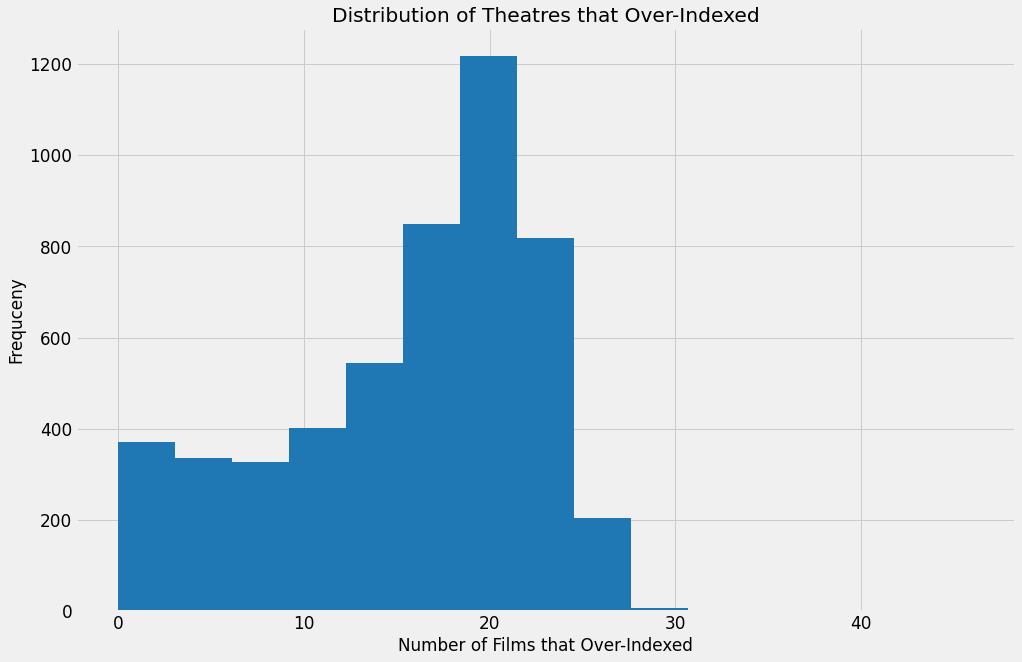

In [118]:
fig, ax = plt.subplots()
ax.hist(oi['over_indexcount'],bins=15,color='tab:blue')
ax.set_xlabel('Number of Films that Over-Indexed')
ax.set_ylabel('Frequceny')
ax.set_title('Distribution of Theatres that Over-Indexed')

In [119]:
# About 80,000 records Over Indexed
over_index = iter4[iter4['over_index'] ==1]

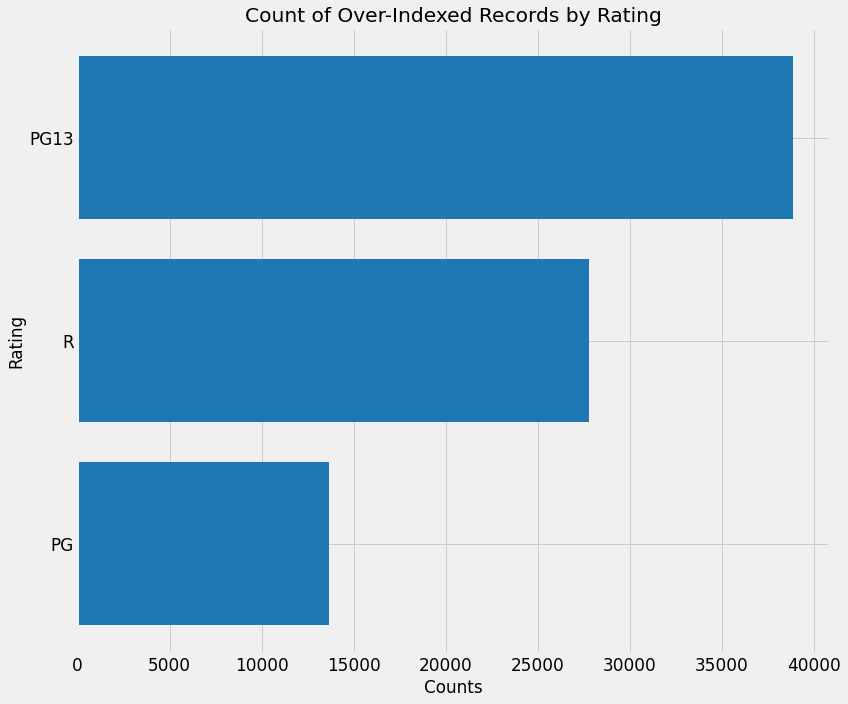

In [120]:
fig, ax = plt.subplots(figsize=(12,10))

ax.barh(over_index['Rating'].value_counts().sort_values().index,
        over_index['Rating'].value_counts().sort_values(),
        color='tab:blue')
ax.set_ylabel('Rating')
ax.set_xlabel('Counts')
ax.set_title('Count of Over-Indexed Records by Rating')
fig.tight_layout()
fig.show()

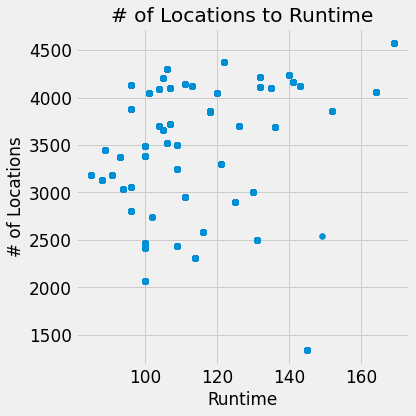

In [123]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(over_index['runtime'],over_index['# of Runs'])
ax.set_ylabel('# of Locations')
ax.set_xlabel('Runtime')
ax.set_title('# of Locations to Runtime')
fig.tight_layout()
fig.show()

# Modelling 

In [126]:
def plot_models(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Logistic Regression
    log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict_proba(X_test).round(3)
    log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)
    
    # Decision Tree
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict_proba(X_test).round(3)
    dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)
    
    # Random Forest
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict_proba(X_test).round(3)
    rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)
    
    # Gradient Boosting
    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict_proba(X_test).round(3)
    gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)
    
    print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
    print('DT: Recall Score - {:.4f}'.format(dt_df['tpr'].mean()))
    print('RF: Recall Score - {:.4f}'.format(rf_df['tpr'].mean()))
    print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    plot_roc(ax1, log_reg_df,log_reg,True)
    plot_roc(ax1, dt_df,dt_model)
    plot_roc(ax1, rf_df,rf_model)
    plot_roc(ax1, gb_df,gb_model)


    plot_precision_recall(ax2, log_reg_df,log_reg,True)
    plot_precision_recall(ax2, dt_df,dt_model)
    plot_precision_recall(ax2, rf_df,rf_model)
    plot_precision_recall(ax2, gb_df,gb_model)

In [127]:
def plot_precision_recall(ax, df, model, random=False):
    label = type(model).__name__ 
    ax.plot(df.tpr,df.precision, label=label)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    if random:
        ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend()

In [128]:
y = iter2_1hot['over_index']
X = iter2_1hot.drop(columns=['over_index'])
#plot_models(X,y)

In [279]:
y = iter4_1hot['over_index']
X = iter4_1hot.drop(columns=['over_index'])
#plot_models(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


LR: Recall Score - 0.6514
DT: Recall Score - 0.6881
RF: Recall Score - 0.6882
GB: Recall Score - 0.6847


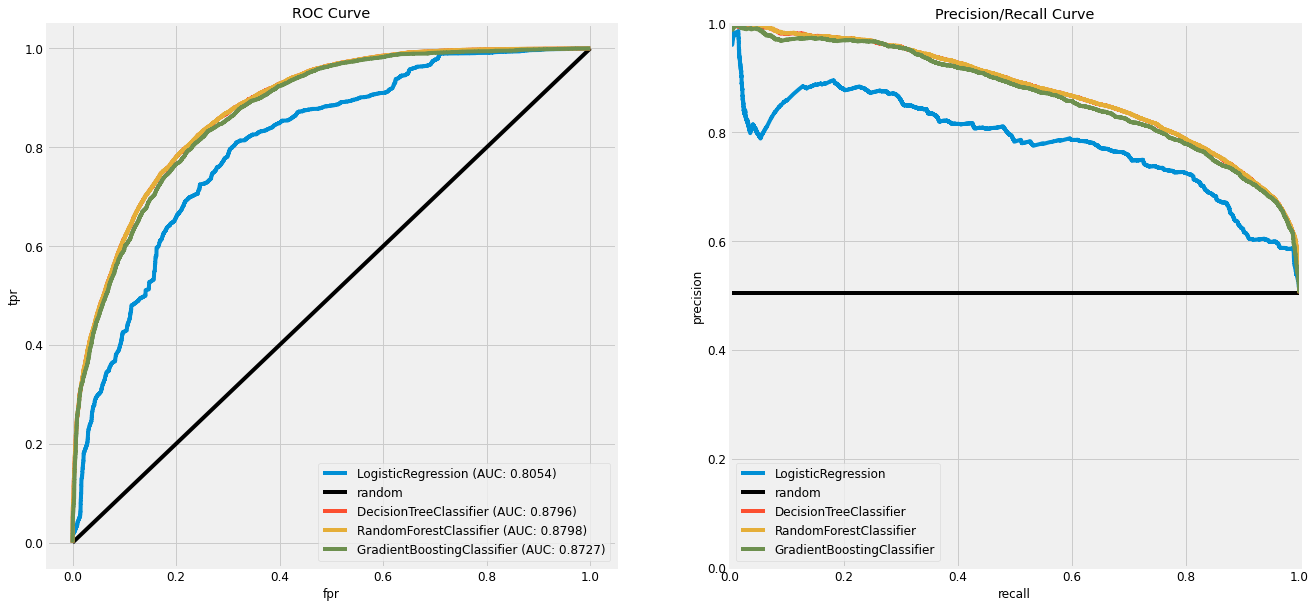

In [202]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

plot_models(X_under,y_under)

In [280]:
X_train_val,X_unseen, y_train_val, y_unseen = train_test_split(X,y,random_state=42)
X_train,X_test, y_train, y_test = train_test_split(X_train_val,y_train_val,random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [281]:
#Logistic Regression
log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test).round(3)
log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


In [ ]:
# Decision Tree
dt_grid = {'max_depth': [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2,5, 10],
            'min_samples_leaf': [2, 5, 7],
            'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='recall')
dt_gridsearch.fit(X_train, y_train)
print("Best parameters:", dt_gridsearch.best_params_)
dt_model = dt_gridsearch.best_estimator_

In [282]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5,max_features='sqrt',min_samples_leaf=2,min_samples_split=2,random_state=1)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       random_state=1)

In [283]:
y_pred_dt = dt_model.predict_proba(X_test).round(3)
dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)

In [ ]:
# Random Forest
rf_grid = {'max_depth': [2, 5, 7],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 10],
            'min_samples_leaf': [2, 4, 8],
            'n_estimators': [100, 150],
            'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

rf_gridsearch.fit(X_train, y_train)
print("Best parameters:", rf_gridsearch.best_params_)
rf_model = rf_gridsearch.best_estimator_

In [284]:
# Random Forest

rf_model = RandomForestClassifier(max_depth=7, 
                                  max_features='sqrt', 
                                  min_samples_leaf=8, 
                                  min_samples_split=2,
                                  n_estimators=150,
                                  random_state=1,
                                  verbose=True)

rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.4s finished


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=8,
                       n_estimators=150, random_state=1, verbose=True)

In [285]:
y_pred_rf = rf_model.predict_proba(X_test).round(3)
rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


In [ ]:
# Gradient Boosting
gb_grid = {'learning_rate': [0.01, 0.05, 0.02],
              'max_depth': [2,4],
              'min_samples_leaf': [2,6,10],
              'n_estimators': [50, 100,200],
              'random_state': [1]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')
gb_gridsearch.fit(X_train, y_train)
print("Best parameters:", gb_gridsearch.best_params_)
gb_model = gb_gridsearch.best_estimator_

In [286]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.05, 
                                      max_depth=4, 
                                      min_samples_leaf=6,
                                      n_estimators=200,
                                      random_state=1,
                                      verbose=True)
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3118            1.38m
         2           1.2860            1.23m
         3           1.2621            1.31m
         4           1.2403            1.19m
         5           1.2205            1.32m
         6           1.2009            1.31m
         7           1.1843            1.38m
         8           1.1678            1.32m
         9           1.1549            1.34m
        10           1.1406            1.30m
        20           1.0445            1.04m
        30           0.9962           54.07s
        40           0.9565           48.86s
        50           0.9323           44.67s
        60           0.9176           41.12s
        70           0.9070           37.75s
        80           0.8978           34.53s
        90           0.8902           31.47s
       100           0.8831           28.48s
       200           0.8519            0.00s


GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=6,
                           n_estimators=200, random_state=1, verbose=True)

In [287]:
y_pred_gb = gb_model.predict_proba(X_test).round(3)
gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)

Unseen GB: Recall Score - 0.7281
GB: Recall Score - 0.7310


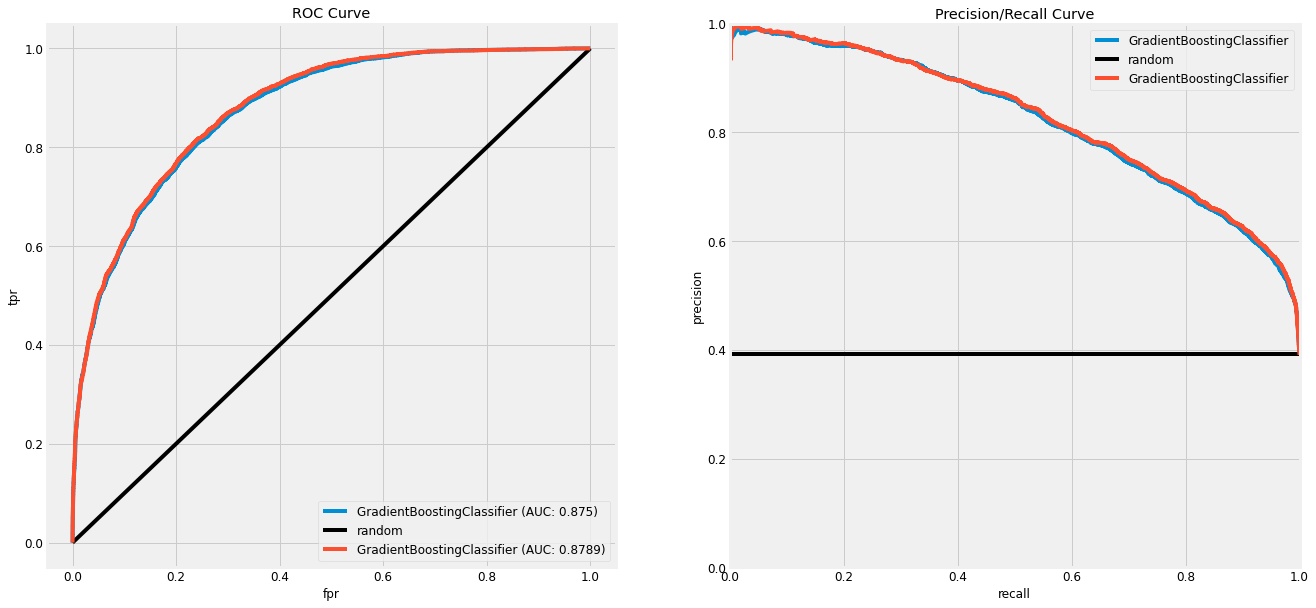

In [288]:
unseen_gb_df = calculate_threshold_values(gb_model.predict_proba(X_unseen)[:, 1], y_unseen)

print('Unseen GB: Recall Score - {:.4f}'.format(unseen_gb_df['tpr'].mean()))
print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, unseen_gb_df,gb_model,True)
plot_roc(ax1, gb_df,gb_model)
plot_precision_recall(ax2, unseen_gb_df,gb_model,True)
plot_precision_recall(ax2, gb_df,gb_model)

In [289]:
'''
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_model.score(X_test,y_test)))
print('RF: Recall Score - {:.4f}'.format(rf_model.score(X_test,y_test)))
print('GB: Recall Score - {:.4f}'.format(gb_model.score(X_test,y_test)))


print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(recall_score(y_test, dt_model.predict(X_test))))
print('RF: Recall Score - {:.4f}'.format(recall_score(y_test, rf_model.predict(X_test))))
print('GB: Recall Score - {:.4f}'.format(recall_score(y_test, gb_model.predict(X_test))))
'''
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_df['tpr'].mean()))
print('RF: Recall Score - {:.4f}'.format(rf_df['tpr'].mean()))
print('GB: Recall Score - {:.4f}'.format(gb_df['tpr'].mean()))



LR: Recall Score - 0.6873
DT: Recall Score - 0.7001
RF: Recall Score - 0.7231
GB: Recall Score - 0.7310


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


LR: Recall Score - 0.3963
DT: Recall Score - 0.8045
RF: Recall Score - 0.8071
GB: Recall Score - 0.8030


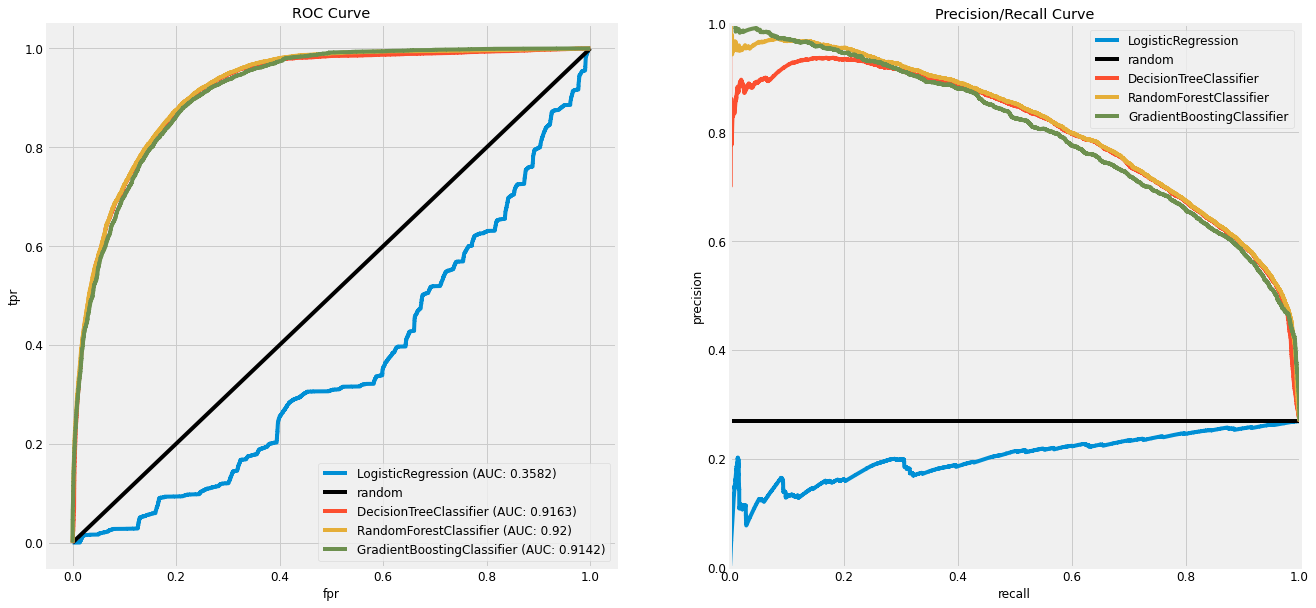

In [301]:
y = baseline['over_index']
X = baseline.drop('over_index',axis=1)
plot_models(X,y)

# ROC Curve, Precision/Recall Curve, and Confusion Matrix

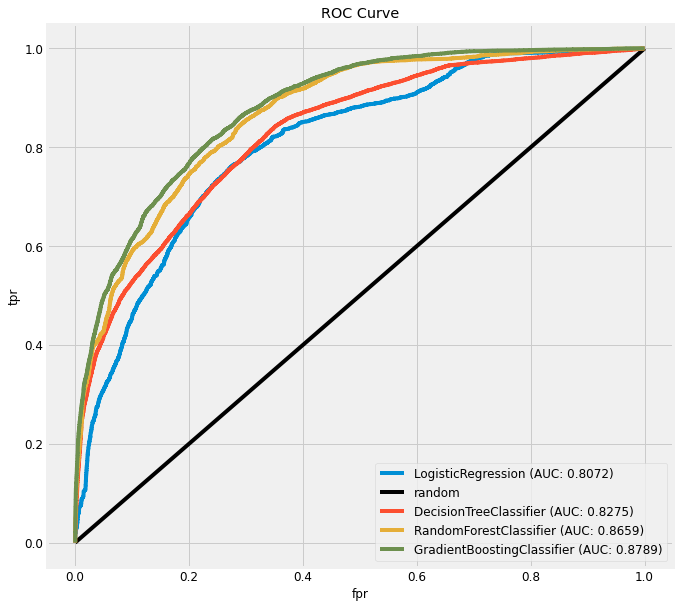

In [300]:
fig, ax1 = plt.subplots( figsize=(10,10))
plot_roc(ax1, log_reg_df,log_reg,True)
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)

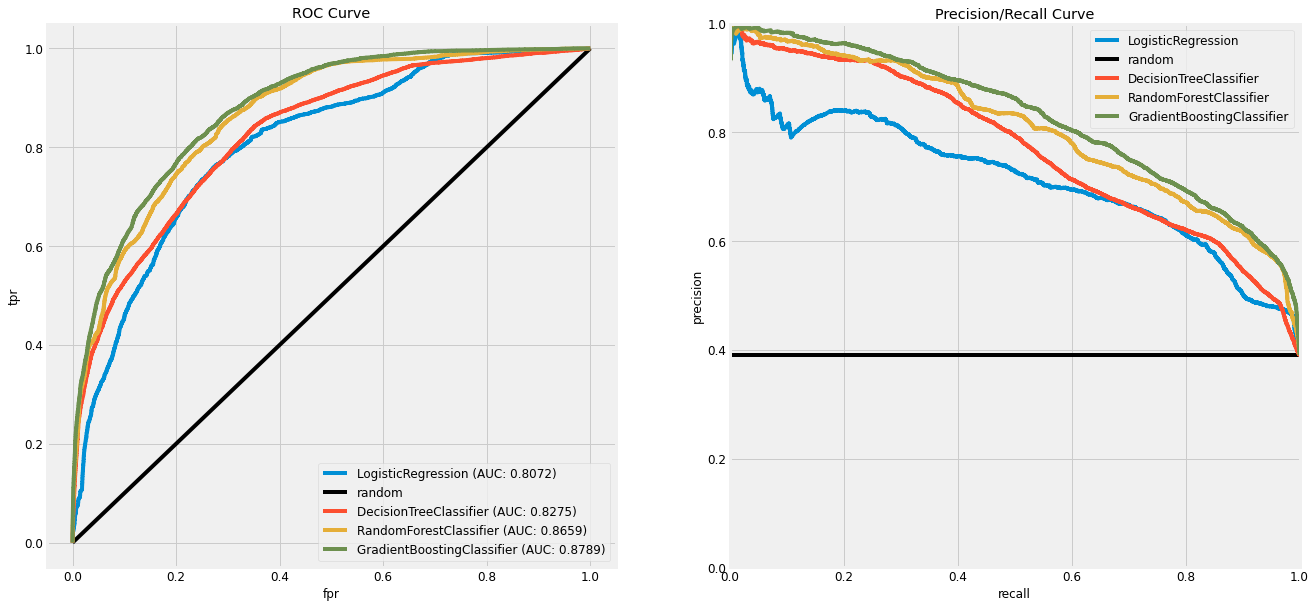

In [298]:
#ROC Curve
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, log_reg_df,log_reg,True)
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)


plot_precision_recall(ax2, log_reg_df,log_reg,True)
plot_precision_recall(ax2, dt_df,dt_model)
plot_precision_recall(ax2, rf_df,rf_model)
plot_precision_recall(ax2, gb_df,gb_model)

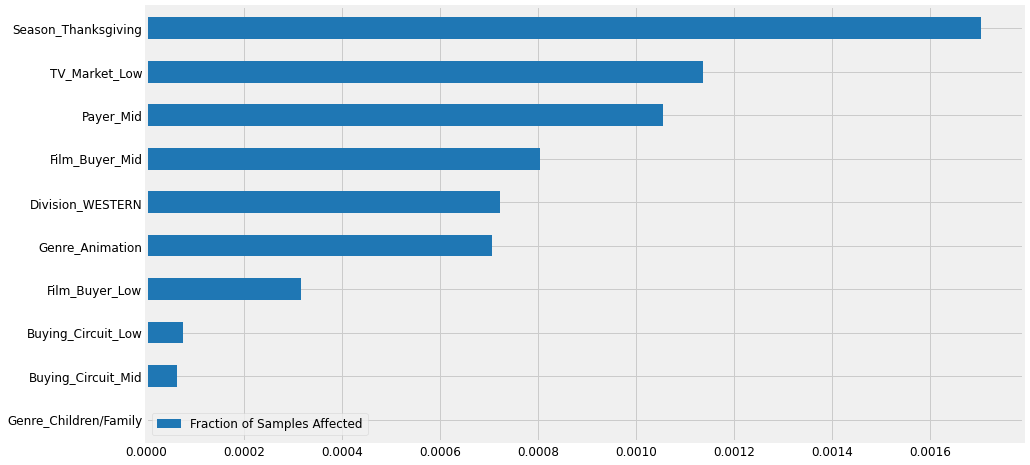

In [291]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected').head(10)
feat_scores.plot(kind='barh', figsize = (14,8),color='tab:blue');

In [292]:
# manual shuffle 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

gb = GradientBoostingClassifier()
scores = defaultdict(list)


names = X.columns
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(10, test_size=.3)

for train_idx, test_idx in tqdm(splitter.split(X, y)):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    gb.fit(X_train, y_train)
    acc = r2_score(y_test, gb.predict(X_test))
    for i in tqdm(range(X.shape[1])):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, gb.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
#scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10))

<AxesSubplot:>

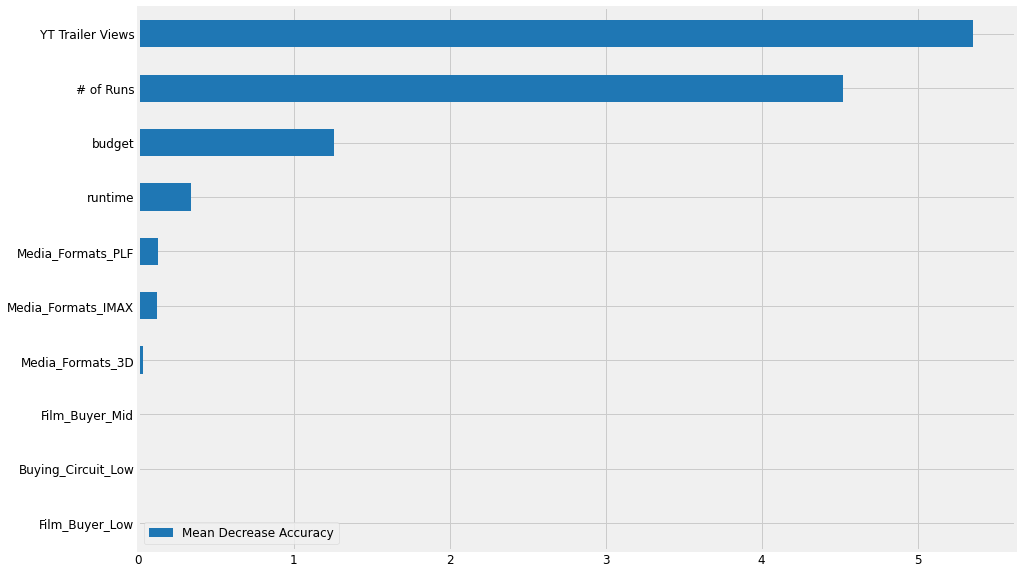

In [295]:
abs(scores).head(10).sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10),color='tab:blue')

Text(0.5, 1.0, 'Confusion Matrix with 50% Threshold')

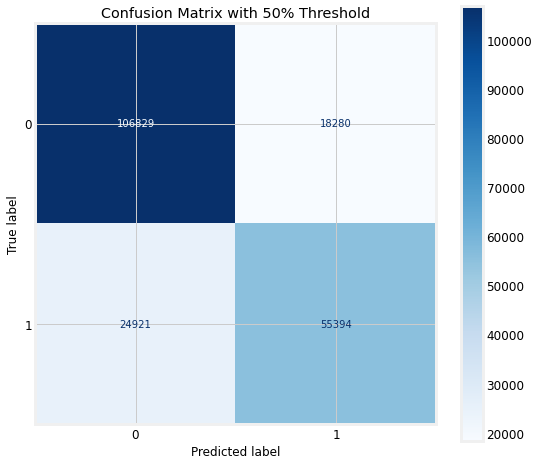

In [296]:
# How to identify proper threshold?
cm = confusion_matrix1(gb_model, X,y, 0.5)

fig, ax = plt.subplots(figsize = (8,8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy())
disp.plot(cmap = plt.cm.Blues, ax = ax)
ax.set_title('Confusion Matrix with 50% Threshold')

In [146]:
cities = ow_df.groupby(['Division','Theatre','City'],as_index=False).last()
cities = cities[cities['Division'] != 'CANADIAN']
cities = cities.groupby(['Theatre','City'],as_index=False).first()[['Theatre','City']]
cities_list = cities['City'].unique().tolist()
city_list = []
for city in tqdm(cities_list):
    city_list.append(str(city).split('#')[0])
cities_dict = dict.fromkeys(city_list)
cities_dict;

In [148]:
cities_dict

{'N CONWAY, NH': None,
 'PORTLAND, OR ': None,
 'STURBRIDGE, MA': None,
 'NEW YORK, NY ': None,
 'TRUCKEE, CA': None,
 'SILVERTON, OR': None,
 'RANDOLPH, MA': None,
 'ELKINS, WV': None,
 'APPLETON, WI': None,
 'SCRANTON, PA': None,
 'BLAIRSVILLE, GA': None,
 'ORINDA, CA': None,
 'MT SHASTA, CA': None,
 'MARION, NC': None,
 'COLORADO SPRINGS, CO': None,
 'AVON, NY': None,
 'NEOSHO, MO': None,
 'RAPID CITY, SD': None,
 'STEPHENVILLE, TX': None,
 'SAN FRANCISCO, CA ': None,
 'JACKSONVILLE, FL ': None,
 'WAUPACA, WI': None,
 'PASADENA, TX ': None,
 'EXTON, PA': None,
 'TAYLORSVILLE, UT': None,
 'MIAMI BEACH, FL ': None,
 'LUBBOCK, TX ': None,
 'CLARKSVILLE, TN ': None,
 'WAPAKONETA, OH': None,
 'SOUTHLAKE, TX': None,
 'HONOLULU, HI ': None,
 'SUFFOLK, VA': None,
 'WEST CHICAGO, IL': None,
 'LIBERAL, KS ': None,
 'LOS ANGELES, CA ': None,
 'ARLINGTON, VA': None,
 'SALISBURY, NC': None,
 'FT LAUDERDALE, FL': None,
 'TUKWILA, WA': None,
 'LAKE BUENA VISTA, FL': None,
 'BERKELEY, CA ': None,
 

In [151]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from geopy.geocoders import Nominatim

,State_Code,geometry
21,MA,"MULTIPOLYGON (((-71.31933 41.77220, -71.33980 ..."
20,MD,"MULTIPOLYGON (((-75.71071 38.64967, -75.70707 ..."
45,VT,"POLYGON ((-73.25806 42.74606, -73.26928 42.747..."
13,IL,"POLYGON ((-88.07159 37.51104, -88.08791 37.476..."
7,DE,"POLYGON ((-75.70707 38.55759, -75.71071 38.649..."
0,AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907..."
32,NY,"MULTIPOLYGON (((-79.76323 42.26733, -79.44402 ..."
2,AZ,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
30,NJ,"POLYGON ((-75.48928 39.71486, -75.47597 39.720..."
25,MO,"POLYGON ((-89.10503 36.95392, -89.12965 36.866..."


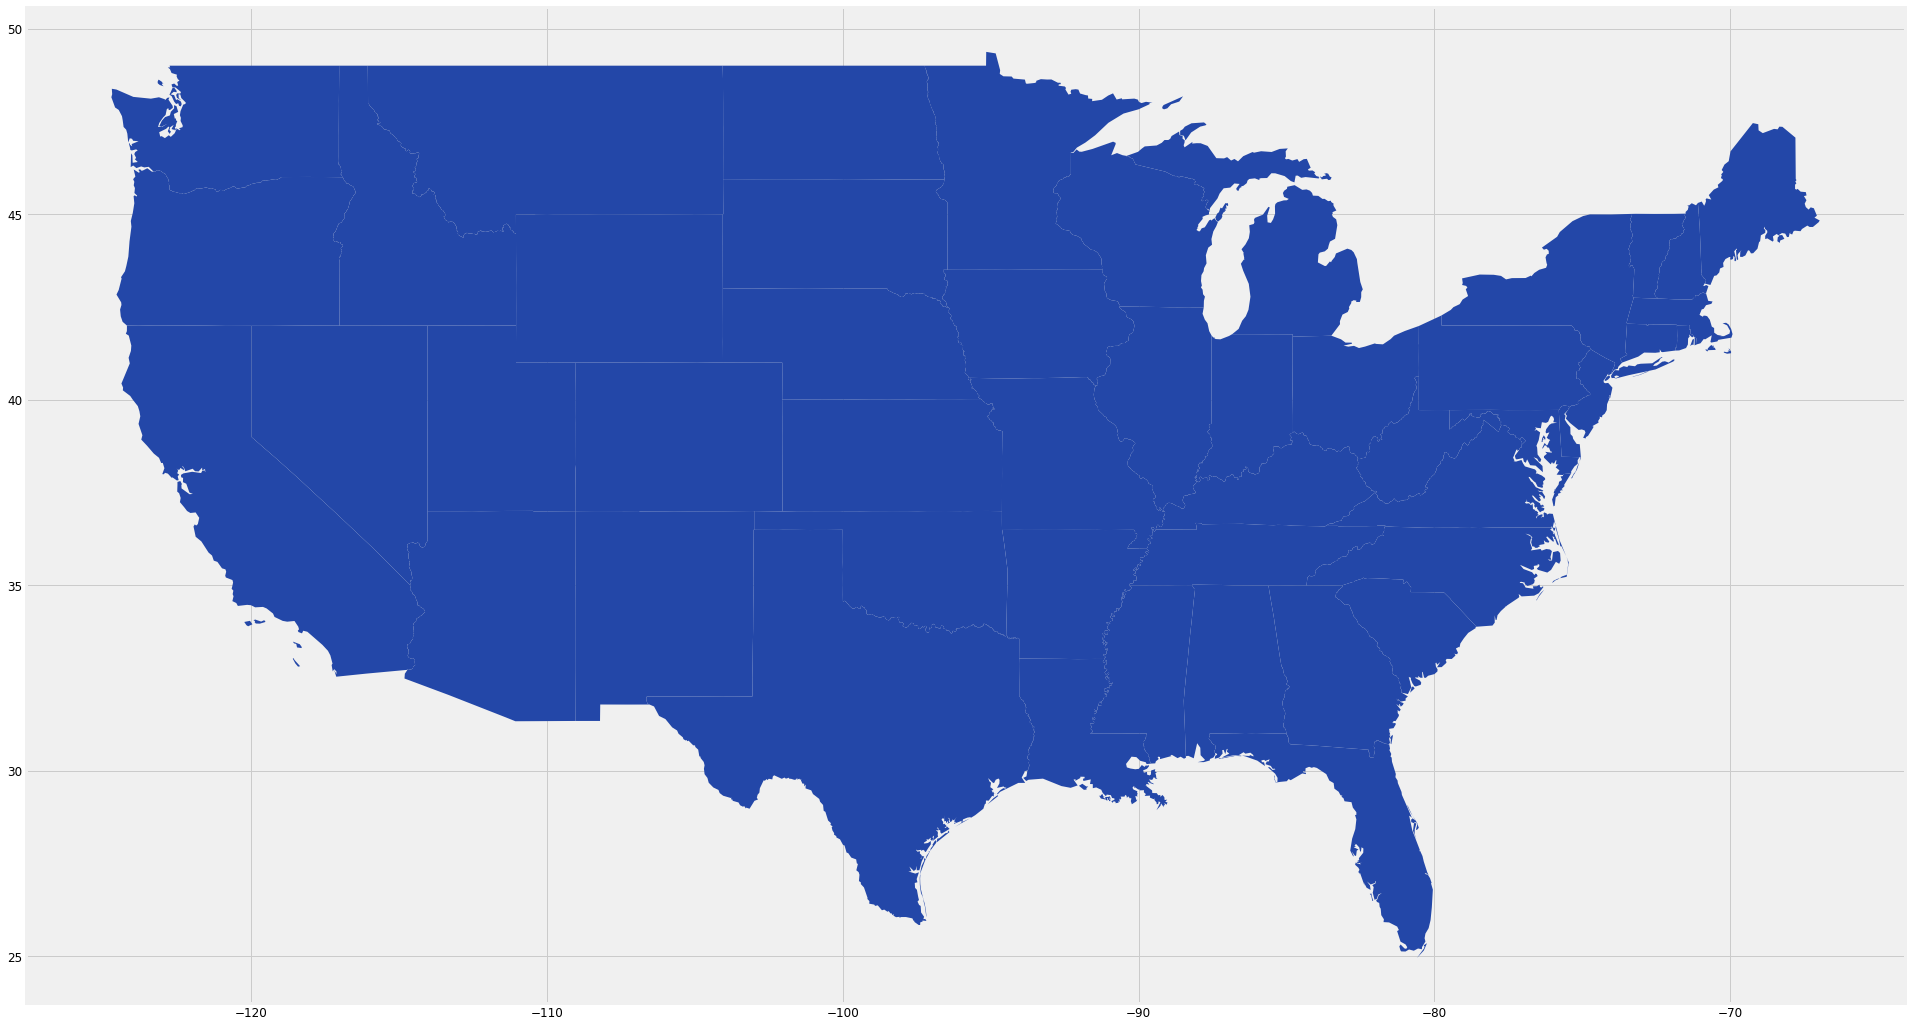

In [166]:
usa = gpd.read_file("data/States_shapefile-shp",encoding="utf-8")
usa = usa[['State_Code','geometry']]
usa = usa[usa['State_Code'].isin(['AK','HI']) == False]
usa.plot(figsize=(30,20), color='#2347a8');
usa

In [167]:
#RUN THIS LATER THIS EVENING
from geopy import geocoders

geolocator = Nominatim(user_agent="over_under_theatres.ipynb")
lat=[]
long=[]

def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
          
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="over_under_theatres.ipynb")
          
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    


for key,value in tqdm(cities_dict.items()):
    if findGeocode(key) != None:
           
        loc = findGeocode(key)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        cities_dict[key] = (loc.longitude,loc.latitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        cities_dict[key] = (np.nan, np.nan)
        
        
    #usa.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(count))*scale)
#plt.show()

In [168]:
city_df = pd.DataFrame.from_dict(cities_dict, orient='index').reset_index()
city_df.columns = ['City','Long','Lat']
city_df.set_index('City',inplace=True)

In [ ]:
city_df.iloc[0][0]

In [ ]:
gdf = gpd.GeoDataFrame(
    city_df, geometry=gpd.points_from_xy(city_df.Long, city_df.Lat))

In [ ]:
gdf_=gdf.reset_index()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
gdf_

In [ ]:
pred = (rf_model.predict_proba(X_test).round(3)[:,1])
type(pred)

In [ ]:
theatre_list = ow_data.groupby('Theatre',as_index=False).first()
theatre_list = theatre_list[['Theatre','Film_Buyer','Buying_Circuit','Payer']].sample(20)
theatre_list['Prob'] = np.random.choice(pred,size=20)
theatre_list.sort_values('Prob',inplace=True,ascending=False)
#theatre_list=theatre_list.merge(gdf_, how='left',on='City')
theatre_list.dropna(axis=0, inplace=True)
theatre_list.head(10)

In [ ]:
sample = gdf.sample(10)

In [ ]:
fig, ax = plt.subplots(1,1)
base = usa[usa['State_Code'].isin(['AK','HI']) == False].plot(ax=ax, color='slategrey')
usa.boundary.plot(ax=ax,linewidth=0.5,color='black')
sample.plot(ax=base, color='darkorange', marker="o", markersize=40)

plt.axis('off')

# Clustering Data

In [ ]:
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
def plot_elbow_sil(df,maxk):
    maxk = maxk
    wcss = []
    sil_scores = []
    for i in tqdm(range(2, maxk)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
        kmeans.fit(df)
        ypred=kmeans.predict(df)
        wcss.append(kmeans.inertia_)    
        labels = kmeans.labels_
        
        score = silhouette_score(df, labels, metric = 'euclidean')
        sil_scores.append(score)
    plt.plot(range(2, maxk), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot Plots
    fig, ax = plt.subplots(figsize=(maxk,10))
    ax.plot(range(2,maxk), sil_scores, 'o-')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette score")

In [ ]:
fm = full_movie.copy()
fm.set_index('Film (Distributor)',inplace=True)
fm.drop(['YT Trailer Views','budget_to_YT'],axis=1,inplace=True)
num_cols = fm.columns[fm.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
scale = StandardScaler()
fm[num_cols]=scale.fit_transform(fm[num_cols])
fm_1hot = pd.get_dummies(fm[['Genre','Season','Rating']],drop_first = True)
fm_1hot
fm_full = fm.join(fm_1hot,how='left')
fm_full = fm_full.drop(['Genre','Season','Rating'],axis=1)

In [ ]:
plot_elbow_sil(fm_full,20)

In [ ]:
#Genre + Movie Clustering
fm_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fm_cluster.fit_predict(fm_full)
fm_full['clusters']=pred_y

cluster_test = fm_full['clusters']
#with pd.option_context("display.max_rows", 1000):
#    display(cluster_test.sort_values())

In [ ]:
fm_num = fm.drop(['Genre','Season','Rating'],axis=1)

fm_std = (fm_num-np.mean(fm_num))/np.std(fm_num)
n_components = 2
fm_pca = PCA(n_components=n_components).fit_transform(fm_std.values)
fm_pca

In [ ]:
plot_elbow_sil(fm_pca,20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(fm_pca[:, 0], fm_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [ ]:
#Movie_PCA Clustering

fm_pca_df = pd.DataFrame(fm_pca, columns = ('PCA1','PCA2'))
fm_ = fm_full.copy().reset_index()
fm_pca_df = fm_.merge(fm_pca_df,how='left',left_index=True,right_index=True)
fm_pca_df.drop(['# of Runs','budget','runtime','Boxoffice_Total','OW to YT','clusters'],axis=1,inplace=True)
fm_pca_df.set_index('Film (Distributor)',inplace=True)
#plot_elbow_sil(fm_pca_df,25)

fmpca_cluster = KMeans(n_clusters=18, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fmpca_cluster.fit_predict(fm_pca)
fm_pca_df['clusters']=pred_y

cluster_test = fm_pca_df['clusters']
#with pd.option_context("display.max_rows", 1000):
#    display(cluster_test.sort_values())

#fm_pca_df

In [ ]:
fm_nobo = fm_full.drop(['# of Runs','Boxoffice_Total','OW to YT','clusters'],axis=1)
plot_elbow_sil(fm_nobo,26)

In [ ]:
#No BO Clustering

nobo_cluster = KMeans(n_clusters=25, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = nobo_cluster.fit_predict(fm_nobo)
fm_nobo['clusters']=pred_y

cluster_test = fm_nobo['clusters']
#with pd.option_context("display.max_rows", 1000):
#    display(cluster_test.sort_values())

# NLP on Plot Overview

In [ ]:
import string
import unicodedata

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser



def extract_bow_from_raw_text(text_as_string):
    """Extracts bag-of-words from a raw text string.

    Parameters
    ----------
    text (str): a text document given as a string

    Returns
    -------
    list : the list of the tokens extracted and filtered from the text
    """
    if (text_as_string == None):
        return []

    if (len(text_as_string) < 1):
        return []

    nfkd_form = unicodedata.normalize('NFKD', text_as_string)
    text_input = str(nfkd_form.encode('ASCII', 'ignore'))

    sent_tokens = sent_tokenize(text_input)

    tokens = list(map(word_tokenize, sent_tokens))

    sent_tags = list(map(pos_tag, tokens))

    grammar = r"""
        SENT: {<(J|N).*>}                # chunk sequences of proper nouns
    """

    cp = RegexpParser(grammar)
    ret_tokens = list()
    lemmatizer = WordNetLemmatizer()
    #stemmer_snowball = SnowballStemmer('english')

    for sent in sent_tags:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'SENT':
                t_tokenlist = [tpos[0].lower() for tpos in subtree.leaves()]
                t_tokens_lemma = list(map(lemmatizer.lemmatize, t_tokenlist))
               # t_tokens_stemsnowball = list(map(stemmer_snowball.stem, t_tokenlist))
                
                ret_tokens.extend(t_tokens_lemma)
                #ret_tokens.extend(t_tokens_stemsnowball)

    return(ret_tokens)
    

In [ ]:
movie_text

In [ ]:
docs = []
for desc in tqdm(movie_text):
    docs.append(desc)

In [ ]:
# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row), docs))

In [ ]:
# displaying bows
#for i in range(len(docs)):
#    print("\n--- Plot: {}".format(docs[i]))
#    print("--- BoW: {}".format(bows[i]))

In [ ]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), bows))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(bows[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
#for i in range(len(docs)):
#    print("\n--- review: {}".format(docs[i]))
#    print("--- bow: {}".format(bows[i]))
#    print("--- term_occ: {}".format(term_occ[i]))
#    print("--- term_freq: {}".format(term_freq[i]))

In [ ]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(docs)))
            for k, v in doc_occ.items()}

# displaying vocabulary
#print("\n--- full vocabulary: {}".format(doc_occ))
#print("\n--- doc freq: {}".format(doc_freq))

In [ ]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.04

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),sorted(vocabulary)))

In [ ]:
import numpy as np

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(docs),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
'''for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))
         '''

In [ ]:
mv_tfidf = pd.DataFrame(data=vectors,columns=sorted(vocabulary))
mv_tfidf = mv_tfidf.rename(columns={"b'in":'in',"b'the":'the',"b'when":'when'})
mv_tfidf.drop('b',axis=1,inplace=True)

mv_tfidf

# PCA

In [ ]:
from sklearn.decomposition import PCA
mv_tfidf_std = (mv_tfidf-np.mean(mv_tfidf))/np.std(mv_tfidf)
n_components = 2
mv_tfidf_pca = PCA(n_components=n_components).fit_transform(mv_tfidf_std.values)
#mv_tf_pca = movies_tfidf_std.values @ pca.components_.T
mv_tfidf_pca

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(mv_tfidf_pca[:, 0], mv_tfidf_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [ ]:
plot_elbow_sil(mv_tfidf_pca,20)

In [ ]:
#with pd.option_context("display.max_rows", 1000):
#    display(genre_df['TITLE'])

In [ ]:
#Movie Clustering + Genre DF for title
pca_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = pca_cluster.fit_predict(mv_tfidf_pca)

mv_pca = pd.DataFrame(mv_tfidf_pca, columns = ('PCA1','PCA2'))
mv_pca = mv_pca.join(genre_df[['TITLE','title']],how='left')
mv_pca['Film (Distributor)'] = mv_pca['title'] 
mv_pca.set_index('Film (Distributor)',inplace=True)
mv_pca['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca['clusters']

#with pd.option_context("display.max_rows", 1000):
#    display(tfidf_cluster_.sort_values())

In [ ]:
# Text PCA + No Boxoffice Dataframe 
mv_pca_full = mv_pca.join(fm_nobo,how='left',lsuffix="_x",rsuffix="_y")
mv_pca_full.drop(['title','TITLE','clusters_x','clusters_y'],axis=1,inplace=True)


In [ ]:
plot_elbow_sil(mv_pca_full,20)

In [ ]:
#Movie Clustering
tfidf_cluster = KMeans(n_clusters=13, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = tfidf_cluster.fit_predict(mv_pca_full)
mv_pca_full['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca_full['clusters']
#with pd.option_context("display.max_rows", 1000):
#    display(tfidf_cluster_.sort_values())

In [ ]:
fm_full_clusters = fm_full.reset_index()[['Film (Distributor)','clusters']]

In [ ]:
iter5_1hot = iter5[['Film (Distributor)','over_index','Media_Formats_3D','Media_Formats_IMAX','Media_Formats_PLF','Division_EASTERN','Division_SOUTHERN','Division_WESTERN']]

In [ ]:
iter5_full = iter5_1hot.merge(fm_full_clusters, how='left',on='Film (Distributor)')
iter5_full.drop('Film (Distributor)',axis=1,inplace=True)

In [ ]:
y = iter5_full['over_index']
X = iter5_full.drop('over_index',axis=1)
plot_models(X,y)